# An example of many-to-one (sequence classification)

Original experiment from [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

Data generation: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/res/sequential_tasks.py

## 1. Dataset Exploration

In [ ]:
!wget https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/sequential_tasks.py
from sequential_tasks import TemporalOrderExp6aSequence as QRSU

--2020-09-15 01:51:24--  https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/sequential_tasks.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9769 (9.5K) [text/plain]
Saving to: ‘sequential_tasks.py.1’

sequential_tasks.py 100%[===================>]   9.54K  --.-KB/s    in 0s      

2020-09-15 01:51:24 (101 MB/s) - ‘sequential_tasks.py.1’ saved [9769/9769]



In [ ]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [ ]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


- What's the input shape?
 - What's the actual length of the sequence? 
 - What's the length as shown using ```.shape```?
- What's the output shape? Why?


## 2. Defining the Model

In [ ]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu',
                                batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]  # Q: dimension of h?
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]  # Q: dimension of h?
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                # Q: what's the type of h_c?
                # Q: what's in h_c?

                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [ ]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Defining the Testing Loop

Important note: In this notebook, we only have training set and test set. In this case, we have to validate on test set.

But when we have training set, development/validation set, and test set, we should not "touch" the test set at all, except at the very end.

In [ ]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 5. Putting it All Together

In [ ]:
!wget https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py
import matplotlib.pyplot as plt
from plot_lib import set_default, plot_state, print_colourbar

--2020-09-15 02:08:56--  https://raw.githubusercontent.com/Atcold/pytorch-Deep-Learning/master/res/plot_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4399 (4.3K) [text/plain]
Saving to: ‘plot_lib.py’

plot_lib.py         100%[===================>]   4.30K  --.-KB/s    in 0s      

2020-09-15 02:08:56 (47.4 MB/s) - ‘plot_lib.py’ saved [4399/4399]



In [ ]:
set_default()

In [ ]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 5. Simple RNN: 10 Epochs

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# How many batches?
print(len(train_data_gen), len(test_data_gen))

# What's the shape within each batch?
print(train_data_gen[17][0].shape, train_data_gen[17][1].shape)

31 31
(32, 81, 8) (32, 4)


[Epoch 1/10] loss: 1.4162, acc: 27.52% - test_loss: 1.4075, test_acc: 24.90%
[Epoch 2/10] loss: 1.3890, acc: 25.71% - test_loss: 1.3808, test_acc: 24.50%
[Epoch 3/10] loss: 1.3977, acc: 24.09% - test_loss: 1.3874, test_acc: 22.48%
[Epoch 4/10] loss: 1.3956, acc: 24.90% - test_loss: 1.3895, test_acc: 24.60%
[Epoch 5/10] loss: 1.3868, acc: 26.11% - test_loss: 1.3814, test_acc: 24.90%
[Epoch 6/10] loss: 1.3853, acc: 23.79% - test_loss: 1.3890, test_acc: 24.09%
[Epoch 7/10] loss: 1.3863, acc: 26.92% - test_loss: 1.3827, test_acc: 25.00%
[Epoch 8/10] loss: 1.3863, acc: 26.41% - test_loss: 1.3831, test_acc: 25.40%
[Epoch 9/10] loss: 1.3941, acc: 27.12% - test_loss: 1.3924, test_acc: 27.02%
[Epoch 10/10] loss: 1.3848, acc: 22.08% - test_loss: 1.3877, test_acc: 25.91%


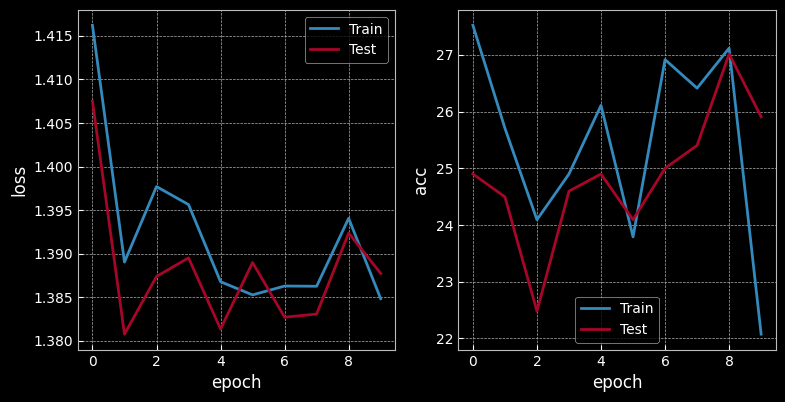

In [ ]:
# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 6
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [ ]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([6, 8])
torch.Size([6, 6])
torch.Size([6])
torch.Size([6])
torch.Size([4, 6])
torch.Size([4])


## 5. Simple LSTM: 10 Epochs

[Epoch 1/10] loss: 1.3827, acc: 27.72% - test_loss: 1.4049, test_acc: 23.59%
[Epoch 2/10] loss: 1.3845, acc: 25.71% - test_loss: 1.3814, test_acc: 27.42%
[Epoch 3/10] loss: 1.3870, acc: 24.50% - test_loss: 1.3866, test_acc: 25.40%
[Epoch 4/10] loss: 1.3838, acc: 26.21% - test_loss: 1.3931, test_acc: 27.72%
[Epoch 5/10] loss: 1.3856, acc: 27.02% - test_loss: 1.3864, test_acc: 25.30%
[Epoch 6/10] loss: 1.3965, acc: 23.59% - test_loss: 1.3900, test_acc: 25.20%
[Epoch 7/10] loss: 1.3838, acc: 26.71% - test_loss: 1.3817, test_acc: 25.91%
[Epoch 8/10] loss: 1.3946, acc: 25.40% - test_loss: 1.3909, test_acc: 25.20%
[Epoch 9/10] loss: 1.3824, acc: 24.19% - test_loss: 1.3907, test_acc: 24.40%
[Epoch 10/10] loss: 1.3879, acc: 24.29% - test_loss: 1.3890, test_acc: 22.48%


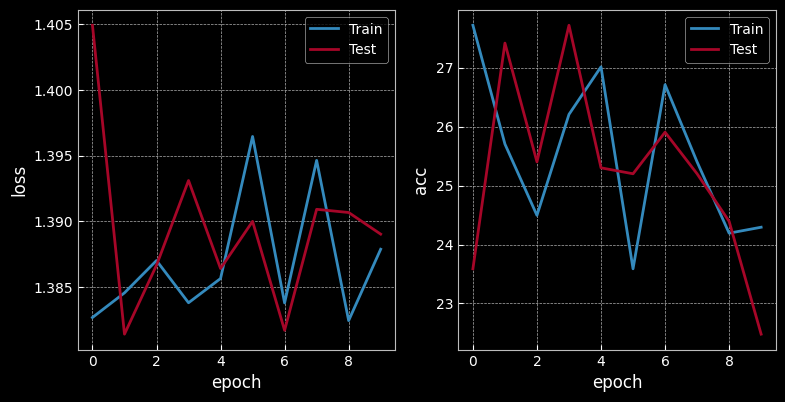

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 6
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [ ]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


## 6. RNN: Increasing Epoch to 100

[Epoch 1/100] loss: 1.4000, acc: 24.09% - test_loss: 1.3770, test_acc: 24.19%
[Epoch 2/100] loss: 1.3687, acc: 26.71% - test_loss: 1.4005, test_acc: 24.90%
[Epoch 3/100] loss: 1.3829, acc: 24.19% - test_loss: 1.3813, test_acc: 23.69%
[Epoch 4/100] loss: 1.3860, acc: 25.30% - test_loss: 1.3913, test_acc: 24.70%
[Epoch 5/100] loss: 1.3878, acc: 22.78% - test_loss: 1.3873, test_acc: 25.50%
[Epoch 6/100] loss: 1.3909, acc: 25.71% - test_loss: 1.3881, test_acc: 23.29%
[Epoch 7/100] loss: 1.3862, acc: 23.89% - test_loss: 1.3841, test_acc: 24.60%
[Epoch 8/100] loss: 1.3968, acc: 27.72% - test_loss: 1.3856, test_acc: 23.89%
[Epoch 9/100] loss: 1.3818, acc: 26.41% - test_loss: 1.3934, test_acc: 25.60%
[Epoch 10/100] loss: 1.3880, acc: 24.70% - test_loss: 1.3844, test_acc: 25.91%
[Epoch 11/100] loss: 1.3948, acc: 26.92% - test_loss: 1.3874, test_acc: 24.60%
[Epoch 12/100] loss: 1.3932, acc: 25.81% - test_loss: 1.3875, test_acc: 28.12%
[Epoch 13/100] loss: 1.3883, acc: 25.60% - test_loss: 1.3832,

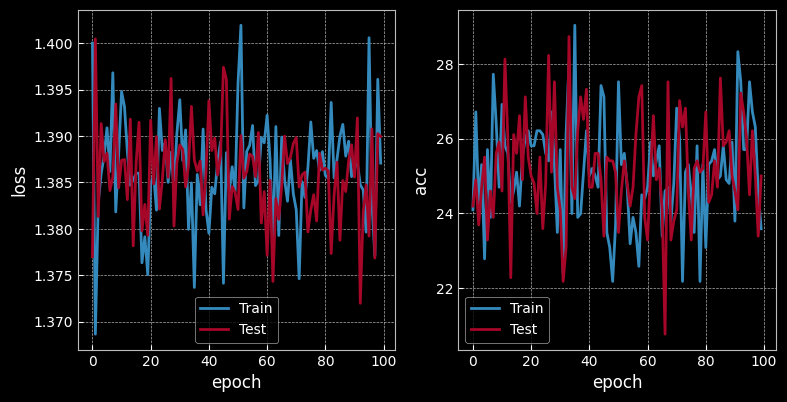

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 6
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model_RNN = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

## LSTM: Increasing Epoch to 100

[Epoch 1/100] loss: 1.3784, acc: 27.72% - test_loss: 1.4024, test_acc: 23.59%
[Epoch 2/100] loss: 1.3857, acc: 25.71% - test_loss: 1.3636, test_acc: 27.42%
[Epoch 3/100] loss: 1.3956, acc: 23.59% - test_loss: 1.3889, test_acc: 27.32%
[Epoch 4/100] loss: 1.3914, acc: 25.20% - test_loss: 1.3952, test_acc: 24.60%
[Epoch 5/100] loss: 1.3818, acc: 24.60% - test_loss: 1.3807, test_acc: 26.61%
[Epoch 6/100] loss: 1.4005, acc: 27.52% - test_loss: 1.3913, test_acc: 25.40%
[Epoch 7/100] loss: 1.3853, acc: 25.40% - test_loss: 1.3831, test_acc: 26.31%
[Epoch 8/100] loss: 1.3921, acc: 23.39% - test_loss: 1.3895, test_acc: 26.71%
[Epoch 9/100] loss: 1.3865, acc: 25.50% - test_loss: 1.3962, test_acc: 23.49%
[Epoch 10/100] loss: 1.3960, acc: 22.48% - test_loss: 1.3862, test_acc: 24.70%
[Epoch 11/100] loss: 1.3898, acc: 24.70% - test_loss: 1.3873, test_acc: 24.19%
[Epoch 12/100] loss: 1.3874, acc: 26.92% - test_loss: 1.3829, test_acc: 27.32%
[Epoch 13/100] loss: 1.3869, acc: 24.19% - test_loss: 1.3852,

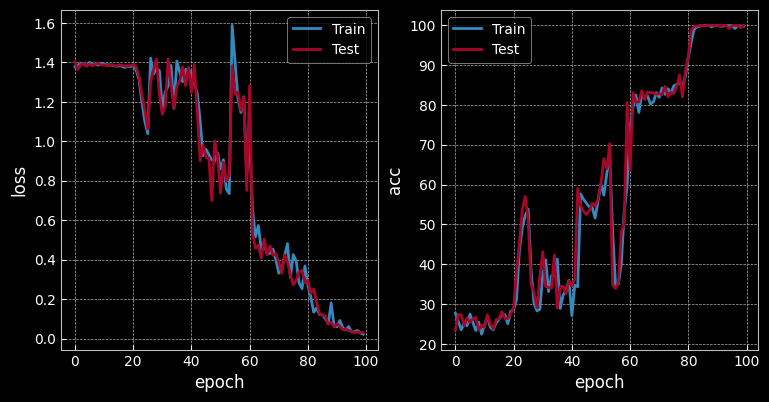

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 6
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model_LSTM = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

## 7. Model Evaluation

In [ ]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.numpy())
            target_decoded = data_generator.decode_y_batch(target.numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\n')

In [ ]:
evaluate_model(model_RNN, difficulty)

The accuracy of the model is measured to be 22.68%.

Q: 0 / 277 correct
R: 0 / 262 correct
S: 0 / 228 correct
U: 225 / 225 correct

Here are some example sequences:
BbcabaddccbcabYdbddcdccbbddccdbbbdbdbdbaddabcaacadbdcbYdddcadcbdcbdcabbbadbaE -> U was labelled U
BbccdabbdcbccYdaacdaddcabcccaabbaabcdaddbcadbacbabcabYabdccdddcaacaaaE -> U was labelled U
BcdabdacddbbbacYadbbaadcbdccabaadbcacdbaccbcdddadcYddcaddddbcdbcbabE -> U was labelled U
BbcabaddccbcabYdbddcdccbbddccdbbbdbdbdbaddabcaacadbdcbYdddcadcbdcbdcabbbadbaE -> U was labelled U
BbaacdcadcbYaaaabaddbbabbbbabcbaabbddbbcdcaddabbYbccdddbbdaaacE -> U was labelled U
BcdbbadbdbdcdYcabdcacbadacccadcaaabcbbcddadcbddbbbdcbaYadbabaaccaabcbbcE -> U was labelled U
BcccbdaaadaabYcbbbabadbadabdadcaaaccbbbcadbdddaccYbadadbccbbdaacdccbdbbadddE -> U was labelled U
BbcabaddccbcabYdbddcdccbbddccdbbbdbdbdbaddabcaacadbdcbYdddcadcbdcbdcabbbadbaE -> U was labelled U
BbaacdcadcbYaaaabaddbbabbbbabcbaabbddbbcdcaddabbYbccdddbbdaaacE -> U was labelled U
Bbc

In [ ]:
evaluate_model(model_LSTM, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 277 / 277 correct
R: 262 / 262 correct
S: 228 / 228 correct
U: 225 / 225 correct

Here are some example sequences:
BdcaddddabcdXacadbcdddbadddcdbbaccdddbabbdcccdcdYaccbaddbdbdaccE -> R was labelled R
BbcabaddccbcabYdbddcdccbbddccdbbbdbdbdbaddabcaacadbdcbYdddcadcbdcbdcabbbadbaE -> U was labelled U
BbcdabbbdacacabcabbXaacaaaaacbbbbabccdadadabdbbdcaaYabcdbddddbdccabbdaE -> R was labelled R
BdbaccbcabcdbbdbXcdbadbcdbcbadbacdbcadbbccabdacbXddccabcbcabcbbabccbcbdbadE -> Q was labelled Q
BdbaccbcabcdbbdbXcdbadbcdbcbadbacdbcadbbccabdacbXddccabcbcabcbbabccbcbdbadE -> Q was labelled Q
BdbddaaadbbdcacXdaaaddaaacacaacccadccababaabdXbccbcadcbbdccabccbaE -> Q was labelled Q
BbcdabbbdacacabcabbXaacaaaaacbbbbabccdadadabdbbdcaaYabcdbddddbdccabbdaE -> R was labelled R
BaabcaddbdXabaaacdaaadbcdcbadaacbccaddbabbaacaddcdYbcdbcbcdcaccbaE -> R was labelled R
BaabcaddbdXabaaacdaaadbcdcbadaacbccaddbabbaacaddcdYbcdbcbcdcaccbaE -> R was labelled R
Bbcabadd

## 8. Visualize LSTM
Setting difficulty to `MODERATE` and `hidden_size` to 12.

[Epoch 1/100] loss: 1.3877, acc: 27.72% - test_loss: 1.4012, test_acc: 23.59%
[Epoch 2/100] loss: 1.3728, acc: 25.71% - test_loss: 1.3768, test_acc: 27.42%
[Epoch 3/100] loss: 1.3862, acc: 23.79% - test_loss: 1.3880, test_acc: 25.50%
[Epoch 4/100] loss: 1.3862, acc: 24.09% - test_loss: 1.3924, test_acc: 24.90%
[Epoch 5/100] loss: 1.3905, acc: 25.50% - test_loss: 1.3896, test_acc: 25.50%
[Epoch 6/100] loss: 1.3953, acc: 25.20% - test_loss: 1.3859, test_acc: 25.81%
[Epoch 7/100] loss: 1.3805, acc: 26.51% - test_loss: 1.3888, test_acc: 26.92%
[Epoch 8/100] loss: 1.3933, acc: 25.30% - test_loss: 1.3898, test_acc: 25.50%
[Epoch 9/100] loss: 1.3828, acc: 26.81% - test_loss: 1.3904, test_acc: 26.51%
[Epoch 10/100] loss: 1.3901, acc: 23.59% - test_loss: 1.3859, test_acc: 26.11%
[Epoch 11/100] loss: 1.3926, acc: 25.30% - test_loss: 1.3871, test_acc: 25.50%
[Epoch 12/100] loss: 1.3952, acc: 27.02% - test_loss: 1.3841, test_acc: 27.12%
[Epoch 13/100] loss: 1.3949, acc: 24.40% - test_loss: 1.3858,

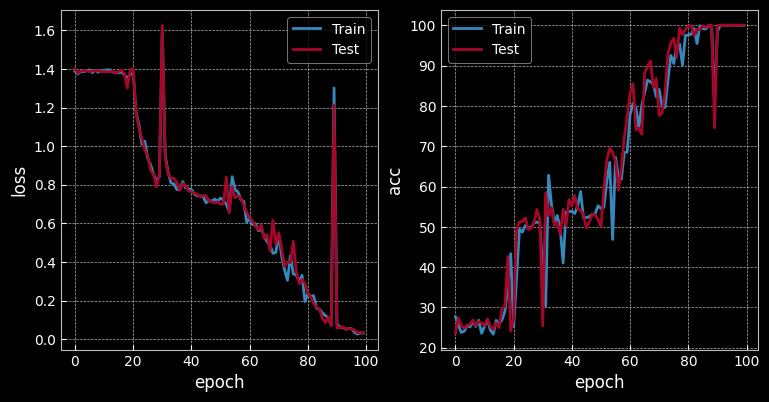

In [ ]:
# For reproducibility
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 10
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

In [ ]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [ ]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


Each row refers to one particular hidden dimension.

In [ ]:
plot_state(X, C_t, b=17, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [ ]:
plot_state(X, H_t, b=17, decoder=test_data_gen.decode_x)

Further resource
- Some explanation of this notebook from last semester
  - https://atcold.github.io/pytorch-Deep-Learning/en/week06/06-3/

### Todo

- See how GRU (Cho et al., 2014) performs.
- Play around with different difficulty levels.
- Play around with different hyperparameters like hidden size and learning rate.